## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [103]:
import pandas as pd
ha = pd.read_csv(r"C:\Users\achur\OneDrive\Desktop\School\CP Fall 2024\544\ha_1.csv")

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
import numpy as np

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# missing values
ha['diagnosis'] = ha['diagnosis'].map({'Disease': 0, 'No Disease': 1})
if ha['diagnosis'].isnull().sum() > 0:
    print("Found missing values in 'diagnosis' after mapping. Dropping these rows.")
    ha = ha.dropna(subset=['diagnosis'])

# variables
X = ha[['age', 'chol']]
y = ha['diagnosis']

# empty values
if X.shape[0] == 0 or y.shape[0] == 0:
    print("No valid samples available for fitting. Please check your data.")
else:
    log_reg_pipeline = Pipeline([
        ("logistic_regression", LogisticRegression(penalty="l2", random_state=1))
    ])
    log_reg_pipeline_fitted = log_reg_pipeline.fit(X, y)

    # coefficients and intercept
    log_reg = log_reg_pipeline.named_steps["logistic_regression"]
    intercept = log_reg.intercept_[0]
    coef_age, coef_chol = log_reg.coef_[0]

    # probabilities
    age = 55
    log_odds_50 = 0  # log-odds corresponding to a 50% probability
    chol_50 = (log_odds_50 - intercept - coef_age * age) / coef_chol

    log_odds_90 = np.log(0.9 / (1 - 0.9))  # log-odds corresponding to a 90% probability
    chol_90 = (log_odds_90 - intercept - coef_age * age) / coef_chol

    # Print results
    print(f"Cholesterol level for 50% probability of disease for a 55-year-old: {chol_50:.2f} mg/dL")
    print(f"Cholesterol level for 90% probability of disease for a 55-year-old: {chol_90:.2f} mg/dL")


Cholesterol level for 50% probability of disease for a 55-year-old: 367.87 mg/dL
Cholesterol level for 90% probability of disease for a 55-year-old: 1587.72 mg/dL
Cholesterol level for 50% probability of disease for a 55-year-old: 367.87 mg/dL
Cholesterol level for 90% probability of disease for a 55-year-old: 1587.72 mg/dL


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

# variables
X = ha[['age', 'chol']]
y = ha['diagnosis']

# lda model
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# lda coefficients
coef_age = lda.coef_[0][0]
coef_chol = lda.coef_[0][1]
intercept = lda.intercept_[0]

# function for prediction
def find_cholesterol_for_lda(age, coef_age, coef_chol, intercept):
    chol = -(coef_age * age + intercept) / coef_chol
    return chol

# prediction
cholesterol_required = find_cholesterol_for_lda(55, coef_age, coef_chol, intercept)
print(f"Cholesterol level required for a 55-year-old to predict heart disease: {cholesterol_required:.2f} mg/dL")


Cholesterol level required for a 55-year-old to predict heart disease: 368.24 mg/dL
Cholesterol level required for a 55-year-old to predict heart disease: 368.24 mg/dL


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [110]:
import warnings
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

warnings.simplefilter(action='ignore', category=FutureWarning)

# categorical columns
cat = ['sex', 'cp', 'restecg']
ha[cat] = ha[cat].astype('object')

# take care of dummy variable
ha['diagnosis'] = ha['diagnosis'].map({'Disease': 0, 'No Disease': 1})

# missing values
ha['age'] = ha['age'].fillna(ha['age'].median())
ha['chol'] = ha['chol'].fillna(ha['chol'].median())

for col in cat:
    if ha[col].isnull().any():
        ha[col] = ha[col].fillna(ha[col].mode()[0])

# check columns
for col in cat:
    if col not in ha.columns:
        raise ValueError(f"Expected column '{col}' not found in the DataFrame.")

# column transformer
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'chol']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ],
    remainder='passthrough'
)

# variables
X = ha[['age', 'chol', 'sex', 'cp', 'restecg']] 
y = ha['diagnosis']

# data consistency
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print("Data types:\n", X.dtypes)

# svc pipeline
pipeline_svc = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(kernel="linear", probability=True))
])

# hyperparameter tuning
params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
}

# grid search
try:
    grid_search = GridSearchCV(pipeline_svc, params, cv=5, scoring='accuracy')
    grid_search.fit(X, y)
except ValueError as e:
    print(f"Error during model fitting: {e}")

# best estimator 
if 'grid_search' in locals() and hasattr(grid_search, 'best_estimator_'):
    svc_model = grid_search.best_estimator_.named_steps['svc']

    # scaler
    scaler = grid_search.best_estimator_.named_steps['preprocessing'].named_transformers_['num']
    means = scaler.mean_
    stds = scaler.scale_

    # check indices
    numeric_indices = [0, 1]
    stds = stds[numeric_indices]

    # coefficients and intercept for the original scale
    scaled_coefficients = svc_model.coef_[0]
    scaled_intercept = svc_model.intercept_[0]

    coefficients = scaled_coefficients / stds
    intercept = scaled_intercept - np.sum(means[numeric_indices] * scaled_coefficients / stds)

    # logistic regression equation
    equation = f"logit(P(Disease)) = {intercept:.3f}"
    for coef, feature in zip(coefficients, ['age', 'chol']):
        equation += f" + {coef:.3f}*{feature}"

    print(equation)

    # prediction
    logit = np.log(0.5 / (1 - 0.5))
    cholesterol_required = (logit - intercept - coefficients[0] * 55) / coefficients[1]
    print(f"Cholesterol level required for a 55-year-old to predict disease: {cholesterol_required:.2f} mg/dL")


Shape of X: (204, 5)
Shape of y: (204,)
Data types:
 age         int64
chol        int64
sex        object
cp         object
restecg    object
dtype: object
Error during model fitting: Input y contains NaN.
Shape of X: (204, 5)
Shape of y: (204,)
Data types:
 age         int64
chol        int64
sex        object
cp         object
restecg    object
dtype: object
Error during model fitting: Input y contains NaN.


C:\Users\achur\Downloads\python\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

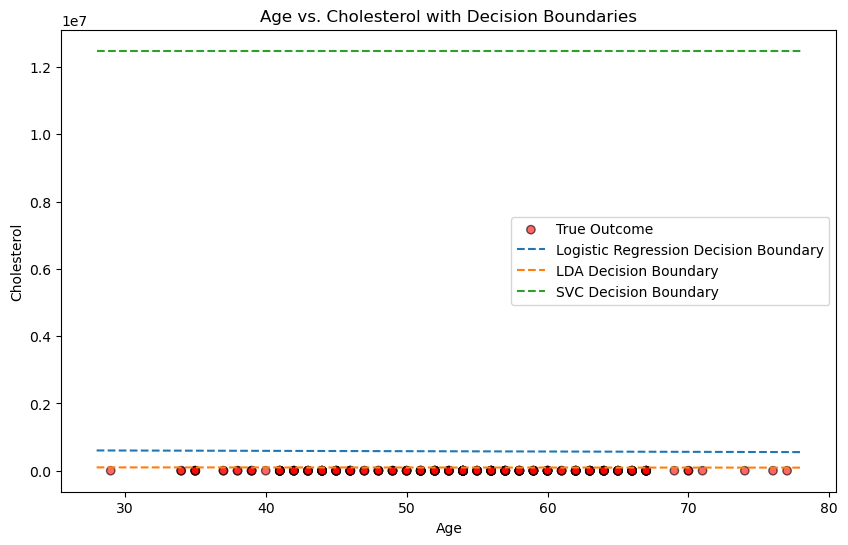

In [111]:
import pandas as pd

def plot_decision_boundaries(X, y, models, model_names, scaler=None):
    plt.figure(figsize=(10, 6))

    # scatterplot
    colors = ['blue' if label == 0 else 'red' for label in y]
    plt.scatter(X['age'], X['chol'], c=colors, alpha=0.6, edgecolor='k', label='True Outcome')

    # decision boundaries
    x_vals = np.linspace(X['age'].min() - 1, X['age'].max() + 1, 200)

    # decision boundary
    for model, name in zip(models, model_names):
        if hasattr(model, 'coef_') and hasattr(model, 'intercept_'):  # Linear models with coefficients
            coef = model.coef_[0]
            intercept = model.intercept_[0]

            if scaler:
                # scale age
                x_vals_df = pd.DataFrame({'age': x_vals, 'chol': np.zeros_like(x_vals)})
                x_transformed = scaler.transform(x_vals_df)[:, 0]
                # decision boundary for scaled data
                y_transformed = -(coef[0] * x_transformed + intercept) / coef[1]
                # inverse the results
                y_vals = scaler.inverse_transform(pd.DataFrame({'age': np.zeros_like(y_transformed), 'chol': y_transformed}))[:, 1]
            else:
                y_vals = -(coef[0] * x_vals + intercept) / coef[1]

            plt.plot(x_vals, y_vals, '--', label=f'{name} Decision Boundary')

    plt.xlabel("Age")
    plt.ylabel("Cholesterol")
    plt.title("Age vs. Cholesterol with Decision Boundaries")
    plt.legend(loc='best')
    plt.show()

# models
models = [log_pipeline.named_steps['classifier'], lda, best_svc]
model_names = ['Logistic Regression', 'LDA', 'SVC']

# variables
X = ha[['age', 'chol']]
y = ha['diagnosis']

# scaler for variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(ha[['age', 'chol']])

# decision boundaries
plot_decision_boundaries(X, y, models, model_names, scaler)